In [16]:
import requests
import csv
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import average_precision_score

HYBRID_URL = "http://localhost:8005/search"
DATASET = "argsme"
FUSION_METHODS = ["weighted_sum", "rrf", "borda"]
TOP_K = 10
DEBUG = True  # اجعلها False لتعطيل التفاصيل

# تحميل الاستعلامات المنظفة
def load_queries(path):
    queries = []
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            queries.append({"query_id": row["query_id"], "query": row["processed_text"]})
    return queries

# تحميل qrels
def load_qrels(path):
    qrels = defaultdict(set)
    with open(path, encoding="utf-8") as f:
        next(f)
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) < 3:
                continue
            qid, docid, rel = parts[:3]
            if int(rel) > 0:
                qrels[qid].add(docid)
    return qrels

# إرسال استعلام إلى خدمة الهجين
def search_fusion(query, method, dataset=DATASET, top_k=TOP_K):
    payload = {
        "dataset": dataset,
        "query": query,
        "top_k": top_k,
        "method": "fusion",
        "tfidf_weight": 0.4,
        "embedding_weight": 0.6,
    }
    if DEBUG:
        print(f"\n[DEBUG] Sending request for method: {method}")
        print(f"Payload: {payload}")
    response = requests.post(HYBRID_URL, json=payload)
    response.raise_for_status()
    results = response.json()["results"]
    if DEBUG:
        print(f"[DEBUG] Received {len(results)} results.")
    # تصفية النتائج لطريقة الدمج المطلوبة
    filtered_results = [r for r in results if r.get("fusion_method") == method]
    if DEBUG:
        print(f"[DEBUG] Filtered {len(filtered_results)} results for fusion method: {method}")
    return filtered_results

# التقييم
def evaluate_fusion_methods(queries, qrels, fusion_methods=FUSION_METHODS, top_k=TOP_K):
    metrics = {m: {"AP": [], "Recall": [], "Precision": []} for m in fusion_methods}
    for q in tqdm(queries, desc="Evaluating queries"):
        qid = q["query_id"]
        query_text = q["query"]
        gt = qrels.get(qid, set())
        print(f"\n=== Query ID: {qid} ===")
        print(f"Query: {query_text}")
        print(f"Relevant docs: {len(gt)}")
        for method in fusion_methods:
            try:
                results = search_fusion(query_text, method)
                pred_docs = [r["doc_id"] for r in results[:top_k]]
                hits = [1 if doc in gt else 0 for doc in pred_docs]
                recall = sum(hits) / len(gt) if gt else 0
                precision = sum(hits) / top_k
                ap = average_precision_score(hits, [1]*len(hits)) if sum(hits) > 0 else 0
                metrics[method]["AP"].append(ap)
                metrics[method]["Recall"].append(recall)
                metrics[method]["Precision"].append(precision)

                # طباعة النتائج لكل كويري وطريقة
                print(f"\n  [Method: {method}]")
                print(f"    Precision@{top_k}: {precision:.4f}")
                print(f"    Recall@{top_k}: {recall:.4f}")
                print(f"    AP: {ap:.4f}")

            except Exception as e:
                print(f"⚠️ Error in query_id={qid} with method {method}: {e}")
                metrics[method]["AP"].append(0)
                metrics[method]["Recall"].append(0)
                metrics[method]["Precision"].append(0)
    # حساب المتوسطات النهائية
    final_results = {}
    for method in fusion_methods:
        final_results[method] = {
            "MAP": sum(metrics[method]["AP"]) / len(metrics[method]["AP"]) if metrics[method]["AP"] else 0,
            "Recall@k": sum(metrics[method]["Recall"]) / len(metrics[method]["Recall"]) if metrics[method]["Recall"] else 0,
            "Precision@k": sum(metrics[method]["Precision"]) / len(metrics[method]["Precision"]) if metrics[method]["Precision"] else 0,
        }
    return final_results


queries_path = "data/vectors/argsme/processed/ARGSME_cleaned_queries.tsv"
qrels_path = "data/vectors/argsme/qrels.tsv"

queries = load_queries(queries_path)
qrels = load_qrels(qrels_path)
results = evaluate_fusion_methods(queries, qrels)

print("\n=== FINAL AVERAGE RESULTS ===")
for method, scores in results.items():
    print(f"Fusion method: {method}")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")



=== Query ID: 1 ===
Query: teacher get tenure user heard country give teacher tenure others dont interested reason tenure user search positive negative argument situation school teacher university professor interest highly relevant argument make clear statement tenure teacher school university relevant argument consider tenure generally specifically teacher instead talk tenure consider situation teacher financial independence
Relevant docs: 10

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'teacher get tenure user heard country give teacher tenure others dont interested reason tenure user search positive negative argument situation school teacher university professor interest highly relevant argument make clear statement tenure teacher school university relevant argument consider tenure generally specifically teacher instead talk tenure consider situation teacher financial independence', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, '

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.8000
    Recall@10: 0.8000
    AP: 0.8000

=== Query ID: 2 ===
Query: vaping ecigarettes safe consider switch smoking vaping user wonder extent vaping safer new risk may involve compare smoking risk clear vaping market benefit raise doubt highly relevant argument support deny safety vaping give valid reason relevant argument argue vaping instead safety vaping comparison smoking respect health effect drug addiction nicotine
Relevant docs: 24

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'vaping ecigarettes safe consider switch smoking vaping user wonder extent vaping safer new risk may involve compare smoking risk clear vaping market benefit raise doubt highly relevant argument support deny safety vaping give valid reason relevant argument argue vaping instead safety vaping comparison smoking respect health effect drug addic

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.3000
    Recall@10: 0.1250
    AP: 0.3000

=== Query ID: 3 ===
Query: insider trading allow since many marketplace liberalize user asks also case situation well inside knowledge company rule insider exploit knowledge appear arbitrary born envy highly relevant argument argue permit insider trading cite cogent valid reason relevant argument include one argue ideologically emotionally illogically otherwise bias
Relevant docs: 20

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'insider trading allow since many marketplace liberalize user asks also case situation well inside knowledge company rule insider exploit knowledge appear arbitrary born envy highly relevant argument argue permit insider trading cite cogent valid reason relevant argument include one argue ideologically emotionally illogically otherwise bias', 'top_k': 10, '

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.0000
    Recall@10: 0.0000
    AP: 0.0000

=== Query ID: 4 ===
Query: corporal punishment use school discipline school associate well learn continued disruption individual spoil student learn success user wonder whether corporal punishment would help discipline disrupt individual provide longlasting effect highly relevant argument include one argue pro con use corporal punishment regard specific situation consider effect disciplinary measure student relevant argument anecdotal one argue punishment general rather corporal punishment
Relevant docs: 47

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'corporal punishment use school discipline school associate well learn continued disruption individual spoil student learn success user wonder whether corporal punishment would help discipline disrupt individual provide longlasting e

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.3000
    Recall@10: 0.0638
    AP: 0.3000

=== Query ID: 5 ===
Query: social security privatize cost social security enormous lot due large government organization inflate bureaucracy user considers whether privatize social security system would beneficial reduce cost due market competition maintain positive impact society highly relevant argument take pro con side privatization social security general specific part system provide reason relevant argument discus privatization general bureaucracy cost emotional erratic subject
Relevant docs: 38

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'social security privatize cost social security enormous lot due large government organization inflate bureaucracy user considers whether privatize social security system would beneficial reduce cost due market competition maintain positiv

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0526
    AP: 0.2000

=== Query ID: 6 ===
Query: college education worth lot educational resource found online day hardly mint company pay lot attention college degree long one demonstrates skill thus user wonder bother get college degree highly relevant argument make statement worthiness college education particular work context mint relevant argument talk benefit formal education alone problem related current system
Relevant docs: 57

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'college education worth lot educational resource found online day hardly mint company pay lot attention college degree long one demonstrates skill thus user wonder bother get college degree highly relevant argument make statement worthiness college education particular work context mint relevant argument talk benefit formal e

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0351
    AP: 0.2000

=== Query ID: 7 ===
Query: felon complete sentence allow vote people commit serious crime position opposite societal norm user wonder whether people thus openly distance basic value society still allow influence outcome election highly relevant argument consider reason voting right felon possibly distinguish different kind felony relevant argument discus human right felon without consider voting right fairness voting right context different limitation
Relevant docs: 52

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'felon complete sentence allow vote people commit serious crime position opposite societal norm user wonder whether people thus openly distance basic value society still allow influence outcome election highly relevant argument consider reason voting right felon possibly 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.1000
    Recall@10: 0.0192
    AP: 0.1000

=== Query ID: 8 ===
Query: abortion legal open question point human life begin moment conception onwards hence right unborn child outweigh mother conversely mother unwanted child well child might suffer year user wonder whether abortion therefore legal highly relevant argument take stance legality abortion cite wellfounded reason relevant argument less wellfounded reason anecdotal emotional erratic
Relevant docs: 90

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'abortion legal open question point human life begin moment conception onwards hence right unborn child outweigh mother conversely mother unwanted child well child might suffer year user wonder whether abortion therefore legal highly relevant argument take stance legality abortion cite wellfounded reason relevant argument le

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.1000
    Recall@10: 0.0111
    AP: 0.1000

=== Query ID: 9 ===
Query: student wear school uniform promote equality key goal school school uniform frequently cite measure accomplish many country school uniform norm whereas others case user wonder whether school uniform introduce country highly relevant argument consider benefit downside school uniform basis arrive conclusion regard question relevant argument take broader perspective uniform school uniform context measure promote equality
Relevant docs: 76

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'student wear school uniform promote equality key goal school school uniform frequently cite measure accomplish many country school uniform norm whereas others case user wonder whether school uniform introduce country highly relevant argument consider benefit downside school uni

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.3000
    Recall@10: 0.0395
    AP: 0.3000

=== Query ID: 10 ===
Query: vaccine require child antivaccination movement rise pathogen like measles freedom vaccinate pair rampant disinformation may threat society large child particular user thus wonder whether vaccine mandatory highly relevant argument name one vaccine reason unnecessity administer child relevant argument talk vaccination child general
Relevant docs: 62

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'vaccine require child antivaccination movement rise pathogen like measles freedom vaccinate pair rampant disinformation may threat society large child particular user thus wonder whether vaccine mandatory highly relevant argument name one vaccine reason unnecessity administer child relevant argument talk vaccination child general', 'top_k': 10, 'method': 'fusion', 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0323
    AP: 0.2000

=== Query ID: 11 ===
Query: performanceenhancing drug accepted sport sport always use measure human capability whereas professional athlete often close performancewise small benefit due drug make difference time drug control sport expensive often unreliable well riddle political influence user wonder left athlete decide whether use drug highly relevant argument make case performanceenhancing drug sport relevant argument talk form performanceenhancements may also due technology rather drug compare sport domain drug use enhance performance
Relevant docs: 43

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'performanceenhancing drug accepted sport sport always use measure human capability whereas professional athlete often close performancewise small benefit due drug make difference time

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.3000
    Recall@10: 0.0698
    AP: 0.3000

=== Query ID: 12 ===
Query: birth control pill available counter easy access birth control pill may repercussion people everyday behavior take precaution disregard negative side effect user wonder whether birth control pill prescription drug doctor chance explain user highly relevant argument argue availability birth control pill without prescription relevant argument argue regard birth control pill side effect argument argue birth control irrelevant
Relevant docs: 43

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'birth control pill available counter easy access birth control pill may repercussion people everyday behavior take precaution disregard negative side effect user wonder whether birth control pill prescription drug doctor chance explain user highly relevant argument argue 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.1000
    Recall@10: 0.0233
    AP: 0.1000

=== Query ID: 13 ===
Query: alternative energy effectively replace fossil fuel give ongoing anthropogenic climate change fossil fuel suppose replace energy source question remains give user one whether nonfossil energy source put together effectively replace fossil fuel highly relevant argument argue thesis fossil fuel entirely replace cite valid reason fact relevant argument discus one form alternative energy fossil fuel
Relevant docs: 60

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'alternative energy effectively replace fossil fuel give ongoing anthropogenic climate change fossil fuel suppose replace energy source question remains give user one whether nonfossil energy source put together effectively replace fossil fuel highly relevant argument argue thesis fossil fuel entirely

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.5000
    Recall@10: 0.0833
    AP: 0.5000

=== Query ID: 14 ===
Query: sexual orientation determine birth give fact homosexuality occurs also specie human nurture may less influence individual behavior user wonder whether human sexuality determine entirely birth highly relevant argument include one argue thesis give reason relevant argument also exhibit emotionality subject intermingle religion thing root science
Relevant docs: 51

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'sexual orientation determine birth give fact homosexuality occurs also specie human nurture may less influence individual behavior user wonder whether human sexuality determine entirely birth highly relevant argument include one argue thesis give reason relevant argument also exhibit emotionality subject intermingle religion thing root science', 'top_

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0392
    AP: 0.2000

=== Query ID: 15 ===
Query: animal use scientific commercial test development drug cosmetic involves animal test user wonder whether really warrant give scale test animal suffer today highly relevant argument consider aspect thesis arrive positive negative conclusion relevant argument consider one two aspect scientific commercial test distinguish two
Relevant docs: 53

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'animal use scientific commercial test development drug cosmetic involves animal test user wonder whether really warrant give scale test animal suffer today highly relevant argument consider aspect thesis arrive positive negative conclusion relevant argument consider one two aspect scientific commercial test distinguish two', 'top_k': 10, 'method': 'fusion', 'tfidf_weight'

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0377
    AP: 0.2000

=== Query ID: 16 ===
Query: prescription drug advertised directly consumer user wonder whether advertising prescription drug ethical term offering patient best care achieve highly relevant argument include talk advertisement health care prescription drug consumer relevant argument talk subset aspect
Relevant docs: 34

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'prescription drug advertised directly consumer user wonder whether advertising prescription drug ethical term offering patient best care achieve highly relevant argument include talk advertisement health care prescription drug consumer relevant argument talk subset aspect', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion meth

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.8000
    Recall@10: 0.2353
    AP: 0.8000

=== Query ID: 17 ===
Query: recreational marijuana legal user living country marijuana outlaw visit netherlands wonder recreational use drug allow highly relevant argument argue favor legalize recreational use relevant argument argue respect marijuana medical use comparison recreational use
Relevant docs: 71

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'recreational marijuana legal user living country marijuana outlaw visit netherlands wonder recreational use drug allow highly relevant argument argue favor legalize recreational use relevant argument argue respect marijuana medical use comparison recreational use', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: weighted_sum



[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0282
    AP: 0.2000

=== Query ID: 18 ===
Query: church remain taxexempt user inclined atheism wonder church exempt tax income charity highly relevant argument take pro con side give valid reason either relevant argument talk tax exemption charity name church example contrast country church taxexempt
Relevant docs: 35

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'church remain taxexempt user inclined atheism wonder church exempt tax income charity highly relevant argument take pro con side give valid reason either relevant argument talk tax exemption charity name church example contrast country church taxexempt', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: weighted_sum

  [Method: weighted_su

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.7000
    Recall@10: 0.2000
    AP: 0.7000

=== Query ID: 19 ===
Query: gay marriage legal straight person user heard debate legalize gay marriage country user deliberates issue may reason legalize gay marriage highly relevant argument make reason statement legality gay marriage relevant argument argue gay right general include gay marriage
Relevant docs: 72

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'gay marriage legal straight person user heard debate legalize gay marriage country user deliberates issue may reason legalize gay marriage highly relevant argument make reason statement legality gay marriage relevant argument argue gay right general include gay marriage', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.1000
    Recall@10: 0.0139
    AP: 0.1000

=== Query ID: 20 ===
Query: drinking milk healthy human drinking milk often portrayed healthy medium whereas user heard also downside lactoseintolerant people hence question whether drinking milk see generally healthy highly relevant argument name positive negative health effect drinking milk either regularly milkbased product relevant argument talk lactose intolerance warrant claim unscientific reason
Relevant docs: 57

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'drinking milk healthy human drinking milk often portrayed healthy medium whereas user heard also downside lactoseintolerant people hence question whether drinking milk see generally healthy highly relevant argument name positive negative health effect drinking milk either regularly milkbased product relevant argument ta

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.5000
    Recall@10: 0.0877
    AP: 0.5000

=== Query ID: 21 ===
Query: human activity primarily responsible global climate change evidence climate change rapidly mount user question common belief climate change anthropogenic desire know whether human primary cause whether cause highly relevant argument include take stance favor oppose climate change anthropogenic offer valid reason either stance relevant argument talk human nonhuman cause primary cause irrelevant argument include one deny climate change
Relevant docs: 58

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'human activity primarily responsible global climate change evidence climate change rapidly mount user question common belief climate change anthropogenic desire know whether human primary cause whether cause highly relevant argument include take stance favor op

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.4000
    Recall@10: 0.0690
    AP: 0.4000

=== Query ID: 22 ===
Query: twostate solution acceptable solution israelipalestinian conflict conflict israel palestinian last long time complicate user wonder whether proposal twostate solution discuss often throughout conflict actually good one highly relevant argument deal conflict arrive specific resolution regard twostate solution base acceptable reason relevant argument discus twostate solution one among many emotional agitate
Relevant docs: 46

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'twostate solution acceptable solution israelipalestinian conflict conflict israel palestinian last long time complicate user wonder whether proposal twostate solution discuss often throughout conflict actually good one highly relevant argument deal conflict arrive specific resolution regar

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.5000
    Recall@10: 0.1087
    AP: 0.5000

=== Query ID: 23 ===
Query: euthanasia physicianassisted suicide legal someone never seriously ill user deliberate whether party policy support euthanasia people wish commit suicide one support oppose highly relevant argument argue favor legality assist suicide relevant argument argue respect moral ethical problem cite anecdotal evidence strongly emotional subject
Relevant docs: 69

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'euthanasia physicianassisted suicide legal someone never seriously ill user deliberate whether party policy support euthanasia people wish commit suicide one support oppose highly relevant argument argue favor legality assist suicide relevant argument argue respect moral ethical problem cite anecdotal evidence strongly emotional subject', 'top_k': 10, 'metho

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.0000
    Recall@10: 0.0000
    AP: 0.0000

=== Query ID: 24 ===
Query: lower federal corporate income tax rate create job time economic crisis usually propose low tax company stabilize economy user wonder whether lower income tax corporation basically always result job creation highly relevant argument specifically discus corporate income tax effect job creation lower relevant argument discus corporate tax generally job create adjust irrelevant argument include one discus tax general
Relevant docs: 34

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'lower federal corporate income tax rate create job time economic crisis usually propose low tax company stabilize economy user wonder whether lower income tax corporation basically always result job creation highly relevant argument specifically discus corporate income tax effect 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0588
    AP: 0.2000

=== Query ID: 25 ===
Query: education free vast difference country world cost high education think fee guarantee high quality others think paid education unfair user wonder system best society subsidize education highly relevant argument specifically discus longterm economical consequence lower increase cost high education relevant argument discus level education shortterm consequence consequence decision example social one
Relevant docs: 61

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'education free vast difference country world cost high education think fee guarantee high quality others think paid education unfair user wonder system best society subsidize education highly relevant argument specifically discus longterm economical consequence lower increase cost high education re

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.1000
    Recall@10: 0.0164
    AP: 0.1000

=== Query ID: 26 ===
Query: standardize test improve education user country education system every state set standard test frequently criticize user asks whether centralization place test everywhere positive net effect overall level education highly relevant argument include one argue standardization explicit premise conclusion improve worsen education outcome relevant argument merely argue standardization leave effect implicit
Relevant docs: 65

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'standardize test improve education user country education system every state set standard test frequently criticize user asks whether centralization place test everywhere positive net effect overall level education highly relevant argument include one argue standardization explicit premise conc

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.1000
    Recall@10: 0.0154
    AP: 0.1000

=== Query ID: 27 ===
Query: gun control law enact user wonder whether liberal policy let everyone carry gun cause harm good hence whether gun control tightly regulate highly relevant argument talk gun control law reason introduce relevant argument agitate emotional way argue less gun control law right
Relevant docs: 61

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'gun control law enact user wonder whether liberal policy let everyone carry gun cause harm good hence whether gun control tightly regulate highly relevant argument talk gun control law reason introduce relevant argument agitate emotional way argue less gun control law right', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.0000
    Recall@10: 0.0000
    AP: 0.0000

=== Query ID: 28 ===
Query: prostitution legal legalization prostitution delicate subject laden strong emotion side user wonder good reason prostitution legal highly relevant argument argue favor oppose legality prostitution relevant argument emotional illogical way explicitly touch legality aspect health may bearing decide legality
Relevant docs: 70

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'prostitution legal legalization prostitution delicate subject laden strong emotion side user wonder good reason prostitution legal highly relevant argument argue favor oppose legality prostitution relevant argument emotional illogical way explicitly touch legality aspect health may bearing decide legality', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEB

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.1000
    Recall@10: 0.0143
    AP: 0.1000

=== Query ID: 29 ===
Query: government allow illegal immigrant become citizen immigrant cross border illegally live user country long time become part society contribute even pay tax aspire become legal citizen user wonder whether good idea whether set bad precedent highly relevant argument discus benefit downside award citizenship illegal immigrant relevant argument discus problem related illegal immigration mention citizenship side note discus topic agitate emotional way
Relevant docs: 69

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'government allow illegal immigrant become citizen immigrant cross border illegally live user country long time become part society contribute even pay tax aspire become legal citizen user wonder whether good idea whether set bad precedent highly rel

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.0000
    Recall@10: 0.0000
    AP: 0.0000

=== Query ID: 30 ===
Query: adult right carry conceal handgun united state state allow carry gun public openly others see state allow conceal user wonder whether carry conceal handgun reasonable measure protect oneself day highly relevant argument discus gun carry right respect handgun concealment relevant argument discus gun carry either regard kind gun reference open gun carry irrelevant argument discus outlaw gun carry
Relevant docs: 52

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'adult right carry conceal handgun united state state allow carry gun public openly others see state allow conceal user wonder whether carry conceal handgun reasonable measure protect oneself day highly relevant argument discus gun carry right respect handgun concealment relevant argument discus gun c

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0385
    AP: 0.2000

=== Query ID: 31 ===
Query: obesity disease increase number population developed country obese thus suffer obesityrelated health problem user wonder obesity classify disease oppose say way life life choice highly relevant argument discus obesity health issue arrive definite answer question possibly oppose relevant argument may clearly state whether obesity disease cite health issue thing related life choice
Relevant docs: 46

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'obesity disease increase number population developed country obese thus suffer obesityrelated health problem user wonder obesity classify disease oppose say way life life choice highly relevant argument discus obesity health issue arrive definite answer question possibly oppose relevant argument may clearly state w

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.7000
    Recall@10: 0.1522
    AP: 0.7000

=== Query ID: 32 ===
Query: electronic voting machine improve voting process digitization affected everyday life voting still relies paper ballot user wonder anything digitization voting might contribute highly relevant argument discus benefit shortcoming electronic voting versus paper voting relevant argument discus one remark digital voting passing
Relevant docs: 25

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'electronic voting machine improve voting process digitization affected everyday life voting still relies paper ballot user wonder anything digitization voting might contribute highly relevant argument discus benefit shortcoming electronic voting versus paper voting relevant argument discus one remark digital voting passing', 'top_k': 10, 'method': 'fusion', 'tfidf_weight'

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.7000
    Recall@10: 0.2800
    AP: 0.7000

=== Query ID: 33 ===
Query: people become vegetarian many user friend become vegetarian recently user wonder whether passing trend whether promote society highly relevant argument include clear statement reason whether society large become vegetarian relevant argument discus vegetarianism standpoint personal inclination
Relevant docs: 55

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'people become vegetarian many user friend become vegetarian recently user wonder whether passing trend whether promote society highly relevant argument include clear statement reason whether society large become vegetarian relevant argument discus vegetarianism standpoint personal inclination', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG] Received 30 results.
[

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.4000
    Recall@10: 0.0727
    AP: 0.4000

=== Query ID: 34 ===
Query: social networking site good society democracy may process disrupt social medium potential creation individual filter bubble user wonder social networking site allow regulate even ban highly relevant argument discus social networking general particular networking site itstheir positive negative effect society relevant argument discus social networking affect people without explicit reference society
Relevant docs: 51

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'social networking site good society democracy may process disrupt social medium potential creation individual filter bubble user wonder social networking site allow regulate even ban highly relevant argument discus social networking general particular networking site itstheir positive negative ef

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0392
    AP: 0.2000

=== Query ID: 35 ===
Query: violent video game contribute youth violence often school shoot medium report computer game shooter play especially highlight case example violent game user wonder whether violent game thus contribute youth violence general highly relevant argument arrive clear verdict effect violent video game youth violence cite valid reason research relevant argument cite anecdotal evidence argue emotionally agitatedly illogically
Relevant docs: 55

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'violent video game contribute youth violence often school shoot medium report computer game shooter play especially highlight case example violent game user wonder whether violent game thus contribute youth violence general highly relevant argument arrive clear verdict effect v

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.0000
    Recall@10: 0.0000
    AP: 0.0000

=== Query ID: 36 ===
Query: golf sport definition sport ambiguous many attempt include one kind activity exclude others hobby golfer make fun friend asks whether golf count sport highly relevant argument argue golf sport cite reason found clear definition term authoritative source relevant argument include slander mention golf passing among example dispute sport
Relevant docs: 38

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'golf sport definition sport ambiguous many attempt include one kind activity exclude others hobby golfer make fun friend asks whether golf count sport highly relevant argument argue golf sport cite reason found clear definition term authoritative source relevant argument include slander mention golf passing among example dispute sport', 'top_k': 10, 'method': 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.7000
    Recall@10: 0.1842
    AP: 0.7000

=== Query ID: 37 ===
Query: cell phone radiation safe cell phone emit significant amount radiation carry around one body whole day even sit next one head bedside table heard rumor cell phone radiation user want know whether kind radiation safe highly relevant argument explain whether cell phone radiation safe relevant argument discus everyday radiation exposure general mention cell phone example
Relevant docs: 27

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'cell phone radiation safe cell phone emit significant amount radiation carry around one body whole day even sit next one head bedside table heard rumor cell phone radiation user want know whether kind radiation safe highly relevant argument explain whether cell phone radiation safe relevant argument discus everyday radiation e

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.8000
    Recall@10: 0.2963
    AP: 0.8000

=== Query ID: 38 ===
Query: marijuana medical option besides use party drug marijuana medical us user wonder whether marijuana use regular basis medical purpose condition highly relevant argument discus marijuana medicine benefit shortcoming relevant argument discus marijuana one example among drug mention medical us passing
Relevant docs: 57

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'marijuana medical option besides use party drug marijuana medical us user wonder whether marijuana use regular basis medical purpose condition highly relevant argument discus marijuana medicine benefit shortcoming relevant argument discus marijuana one example among drug mention medical us passing', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG] Received 30 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.1000
    Recall@10: 0.0175
    AP: 0.1000

=== Query ID: 39 ===
Query: federal minimum wage increase minimum wage necessary allow living country often point discussion user wonder raise minimum wage reasonable allow lowpaid worker live well life highly relevant argument argue raise minimum wage cite relevant reason relevant argument discus wage general argue emotion agitation
Relevant docs: 63

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'federal minimum wage increase minimum wage necessary allow living country often point discussion user wonder raise minimum wage reasonable allow lowpaid worker live well life highly relevant argument argue raise minimum wage cite relevant reason relevant argument discus wage general argue emotion agitation', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[D

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0317
    AP: 0.2000

=== Query ID: 40 ===
Query: death penalty allow promoter capital punishment often argue death penalty ultimate way prevent extreme crime user wonder case whether sufficient cause legalize death penalty highly relevant argument make clear statement death penalty whether allow cite valid reason relevant argument emotional subject discus death penalty alternative punishment
Relevant docs: 84

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'death penalty allow promoter capital punishment often argue death penalty ultimate way prevent extreme crime user wonder case whether sufficient cause legalize death penalty highly relevant argument make clear statement death penalty whether allow cite valid reason relevant argument emotional subject discus death penalty alternative punishment', 'top_

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.1000
    Recall@10: 0.0119
    AP: 0.1000

=== Query ID: 41 ===
Query: student loan debt easy discharge bankruptcy student tuition high country student financial dept verge bankruptcy user wonder whether student give time low interest rate discharge debt highly relevant argument cover aspect question student loan debt student bankruptcy study finish relief form easy discharge debt take clear pro con stance relevant argument cover subset aspect question
Relevant docs: 33

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'student loan debt easy discharge bankruptcy student tuition high country student financial dept verge bankruptcy user wonder whether student give time low interest rate discharge debt highly relevant argument cover aspect question student loan debt student bankruptcy study finish relief form easy discharge debt 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.3000
    Recall@10: 0.0909
    AP: 0.3000

=== Query ID: 42 ===
Query: fight allow hockey ice hockey tackle appear key part game cause lot penalty lot injury moreover audience seem expect violence user wonder allow highly relevant argument discus whether fight key part game give valid reason relevant argument discus fight sport general mention hockey among sport emotional agitate
Relevant docs: 23

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'fight allow hockey ice hockey tackle appear key part game cause lot penalty lot injury moreover audience seem expect violence user wonder allow highly relevant argument discus whether fight key part game give valid reason relevant argument discus fight sport general mention hockey among sport emotional agitate', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight':

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.9000
    Recall@10: 0.3913
    AP: 0.9000

=== Query ID: 43 ===
Query: bottle water ban tap water valid alternative bottle water user wonder tap water norm whether safe resource bottle water ban highly relevant argument argue bottle water give clear reason conclusion relevant argument mention specific kind bottle water plastic bottle drinking water quality industry general
Relevant docs: 38

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'bottle water ban tap water valid alternative bottle water user wonder tap water norm whether safe resource bottle water ban highly relevant argument argue bottle water give clear reason conclusion relevant argument mention specific kind bottle water plastic bottle drinking water quality industry general', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG] 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.7000
    Recall@10: 0.1842
    AP: 0.7000

=== Query ID: 44 ===
Query: election day national holiday election held workday cause problem work people attend especially wait line long user wonder whether election day holiday maximize voter participation highly relevant argument explain make election day holiday good idea relevant argument mention fact remedy one problem election
Relevant docs: 13

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'election day national holiday election held workday cause problem work people attend especially wait line long user wonder whether election day holiday maximize voter participation highly relevant argument explain make election day holiday good idea relevant argument mention fact remedy one problem election', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}


[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.1538
    AP: 0.2000

=== Query ID: 45 ===
Query: penny stay circulation inflation cause small coin currency almost worthless people halfjoking pick penny street expensive user wonder whats point keep penny circulation highly relevant argument make compelling case penny stay circulation remove relevant argument discus small coin money general also include paper money compare digital money
Relevant docs: 40

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'penny stay circulation inflation cause small coin currency almost worthless people halfjoking pick penny street expensive user wonder whats point keep penny circulation highly relevant argument make compelling case penny stay circulation remove relevant argument discus small coin money general also include paper money compare digital money', 'top_k': 10, 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.3000
    Recall@10: 0.0750
    AP: 0.3000

=== Query ID: 46 ===
Query: net neutrality restore give preference kind network traffic kind long question possible user wonder whether neutral shipment data reintroduce highly relevant argument make case net neutrality reintroduce relevant argument merely state importance certain kind traffic example
Relevant docs: 46

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'net neutrality restore give preference kind network traffic kind long question possible user wonder whether neutral shipment data reintroduce highly relevant argument make case net neutrality reintroduce relevant argument merely state importance certain kind traffic example', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion 

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.0435
    AP: 0.2000

=== Query ID: 47 ===
Query: homework beneficial many school child get assign homework user wonder whether common practice education system actually beneficial learn outcome highly relevant argument give reason homework assignment relevant argument mention homework one many measure appear discuss learn benefit downside benefit downside related thing
Relevant docs: 55

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'homework beneficial many school child get assign homework user wonder whether common practice education system actually beneficial learn outcome highly relevant argument give reason homework assignment relevant argument mention homework one many measure appear discuss learn benefit downside benefit downside related thing', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.5000
    Recall@10: 0.0909
    AP: 0.5000

=== Query ID: 48 ===
Query: voting age lower exclude certain part society voting appear undemocratic child entirely exclude across globe user wonder case whether voting age lower highly relevant argument take stance lower voting age cite significant shortcoming benefit relevant argument discus childrens right mention voting example
Relevant docs: 41

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'voting age lower exclude certain part society voting appear undemocratic child entirely exclude across globe user wonder case whether voting age lower highly relevant argument take stance lower voting age cite significant shortcoming benefit relevant argument discus childrens right mention voting example', 'top_k': 10, 'method': 'fusion', 'tfidf_weight': 0.4, 'embedding_weight': 0.6}
[DEBUG

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.3000
    Recall@10: 0.0732
    AP: 0.3000

=== Query ID: 49 ===
Query: body camera mandatory police many instance police brutality document throughout world user wonder whether make body cam mandatory would suitable measure attempt minimize crime highly relevant argument argue body cam police officer give valid reason relevant argument include one cite conspiracy theory discus video surveillance general mention body cam passing
Relevant docs: 33

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'body camera mandatory police many instance police brutality document throughout world user wonder whether make body cam mandatory would suitable measure attempt minimize crime highly relevant argument argue body cam police officer give valid reason relevant argument include one cite conspiracy theory discus video surveillance general me

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.7000
    Recall@10: 0.2121
    AP: 0.7000

=== Query ID: 50 ===
Query: everyone get universal basic income redistribution wealth fundamental concept many economy social system key component might universal basic income however user wonder whether truly would help highly relevant argument take clear stance toward universal basic income give clear premise relevant argument offer emotional argument talk minimum wage mention universal basic income passing
Relevant docs: 20

[DEBUG] Sending request for method: weighted_sum
Payload: {'dataset': 'argsme', 'query': 'everyone get universal basic income redistribution wealth fundamental concept many economy social system key component might universal basic income however user wonder whether truly would help highly relevant argument take clear stance toward universal basic income give clear premise relevant argument offer emoti


Evaluating queries: 100%|██████████| 50/50 [23:09<00:00, 27.79s/it]

[DEBUG] Received 30 results.
[DEBUG] Filtered 10 results for fusion method: borda

  [Method: borda]
    Precision@10: 0.2000
    Recall@10: 0.1000
    AP: 0.2000

=== FINAL AVERAGE RESULTS ===
Fusion method: weighted_sum
  MAP: 0.3080
  Recall@k: 0.0907
  Precision@k: 0.3080
Fusion method: rrf
  MAP: 0.3160
  Recall@k: 0.0951
  Precision@k: 0.3160
Fusion method: borda
  MAP: 0.3180
  Recall@k: 0.0964
  Precision@k: 0.3180


In [4]:
import requests
import csv
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score, ndcg_score

HYBRID_URL = "http://localhost:8005/search"
DATASET = "argsme"
FUSION_METHODS = ["weighted_sum", "rrf", "borda"]
TOP_K = 100  # Increased for better recall and NDCG

# Load cleaned queries
def load_queries(path):
    queries = []
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            queries.append({"query_id": row["query_id"], "query": row["processed_text"]})
    return queries

# Load qrels
def load_qrels(path):
    qrels = defaultdict(dict)
    with open(path, encoding="utf-8") as f:
        next(f)
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) < 3:
                continue
            qid, docid, rel = parts[:3]
            qrels[qid][docid] = int(rel)
    return qrels

# Send query to hybrid search service
def search_fusion(query, method, dataset=DATASET, top_k=TOP_K):
    payload = {
        "dataset": dataset,
        "query": query,
        "top_k": top_k,
        "method": "fusion",
        "tfidf_weight": 0.4,
        "embedding_weight": 0.6,
    }
    response = requests.post(HYBRID_URL, json=payload)
    response.raise_for_status()
    results = response.json()["results"]
    return [r for r in results if r.get("fusion_method") == method]

# Evaluate fusion methods
def evaluate_fusion_methods(queries, qrels, fusion_methods=FUSION_METHODS, top_k=TOP_K):
    metrics = {m: {"AP": [], "Recall": [], "Precision": [], "NDCG": []} for m in fusion_methods}

    for q in tqdm(queries, desc="Evaluating queries"):
        qid = q["query_id"]
        query_text = q["query"]
        gt = qrels.get(qid, {})
        if not gt:
            continue

        print(f"\n=== Query ID: {qid} ===")
        print(f"Query: {query_text[:100]}...")  # Print first 100 chars of query
        print(f"Relevant documents: {len(gt)}")

        for method in fusion_methods:
            try:
                results = search_fusion(query_text, method)
                pred_docs = [r["doc_id"] for r in results[:top_k]]
                pred_scores = [r["score"] for r in results[:top_k]]

                hits = [1 if doc in gt else 0 for doc in pred_docs]

                precision = sum(hits[:10]) / 10  # Precision@10
                recall = sum(hits) / len(gt) if gt else 0
                ap = average_precision_score(hits, [1]*len(hits)) if sum(hits) > 0 else 0

                true_rels = [gt.get(doc, 0) for doc in pred_docs]
                ndcg = ndcg_score([true_rels], [pred_scores]) if sum(true_rels) > 0 else 0

                metrics[method]["AP"].append(ap)
                metrics[method]["Recall"].append(recall)
                metrics[method]["Precision"].append(precision)
                metrics[method]["NDCG"].append(ndcg)

                # Print per-query metrics
                print(f"\n  Method: {method}")
                print(f"    Precision@10: {precision:.4f}")
                print(f"    Recall@{top_k}: {recall:.4f}")
                print(f"    AP: {ap:.4f}")
                print(f"    NDCG@{top_k}: {ndcg:.4f}")

            except Exception as e:
                print(f"Error in query_id={qid} with method {method}: {e}")
                metrics[method]["AP"].append(0)
                metrics[method]["Recall"].append(0)
                metrics[method]["Precision"].append(0)
                metrics[method]["NDCG"].append(0)

    # Compute averages per fusion method
    final_results = {}
    for method in fusion_methods:
        final_results[method] = {
            "MAP": sum(metrics[method]["AP"]) / len(metrics[method]["AP"]) if metrics[method]["AP"] else 0,
            "Recall@k": sum(metrics[method]["Recall"]) / len(metrics[method]["Recall"]) if metrics[method]["Recall"] else 0,
            "Precision@10": sum(metrics[method]["Precision"]) / len(metrics[method]["Precision"]) if metrics[method]["Precision"] else 0,
            "NDCG@k": sum(metrics[method]["NDCG"]) / len(metrics[method]["NDCG"]) if metrics[method]["NDCG"] else 0,
        }
    return final_results

# Run evaluation
queries_path = "data/vectors/argsme/processed/ARGSME_cleaned_queries.tsv"
qrels_path = "data/vectors/argsme/qrels.tsv"

queries = load_queries(queries_path)
qrels = load_qrels(qrels_path)
results = evaluate_fusion_methods(queries, qrels)

# Print final averages
print("\n=== Final Results Per Fusion Method ===")
for method, scores in results.items():
    print(f"\nFusion method: {method}")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


Evaluating queries:   0%|          | 0/50 [00:00<?, ?it/s]


=== Query ID: 1 ===
Query: teacher get tenure user heard country give teacher tenure others dont interested reason tenure user ...
Relevant documents: 23

  Method: weighted_sum
    Precision@10: 0.8000
    Recall@100: 0.6522
    AP: 0.1500
    NDCG@100: 0.7419

  Method: rrf
    Precision@10: 0.7000
    Recall@100: 0.6522
    AP: 0.1500
    NDCG@100: 0.6410

  Method: borda
    Precision@10: 0.2000
    Recall@100: 0.6522
    AP: 0.1500
    NDCG@100: 0.4858

=== Query ID: 2 ===
Query: vaping ecigarettes safe consider switch smoking vaping user wonder extent vaping safer new risk may ...
Relevant documents: 45

  Method: weighted_sum
    Precision@10: 0.3000
    Recall@100: 0.2000
    AP: 0.0900
    NDCG@100: 0.4059

  Method: rrf
    Precision@10: 0.4000
    Recall@100: 0.1556
    AP: 0.0700
    NDCG@100: 0.6329

  Method: borda
    Precision@10: 0.0000
    Recall@100: 0.2000
    AP: 0.0900
    NDCG@100: 0.3613

=== Query ID: 3 ===
Query: insider trading allow since many marketplace l

 Evaluating all queries:   0%|          | 0/1444 [00:00<?, ?it/s]


 Query ID: 123839
 Query: yanni
 Relevant docs: 6
   [Method: weighted_sum]
    Precision@1000: 0.0000
    Recall@1000: 0.0000
    AP: 0.0000
    NDCG@1000: 0.0000
     Top 5 Retrieved: []
     Relevant Retrieved: []
   [Method: rrf]
    Precision@1000: 0.0090
    Recall@1000: 1.5000
    AP: 0.2508
    NDCG@1000: 0.5547
     Top 5 Retrieved: ['2129172', '123839', '1709594', '2293779', '1076430']
     Relevant Retrieved: ['123839']
   [Method: borda]
    Precision@1000: 0.0090
    Recall@1000: 1.5000
    AP: 0.0819
    NDCG@1000: 0.4169
     Top 5 Retrieved: ['2129172', '123839', '1709594', '2293779', '1076430']
     Relevant Retrieved: ['123839']

 Query ID: 188629
 Query: k pop
 Relevant docs: 6
   [Method: weighted_sum]
    Precision@1000: 0.0060
    Recall@1000: 1.0000
    AP: 0.1148
    NDCG@1000: 0.4660
     Top 5 Retrieved: ['251586', '188629', '2360963', '2137048', '1274659']
     Relevant Retrieved: ['188629']
   [Method: rrf]
    Precision@1000: 0.0100
    Recall@1000: 1.6667

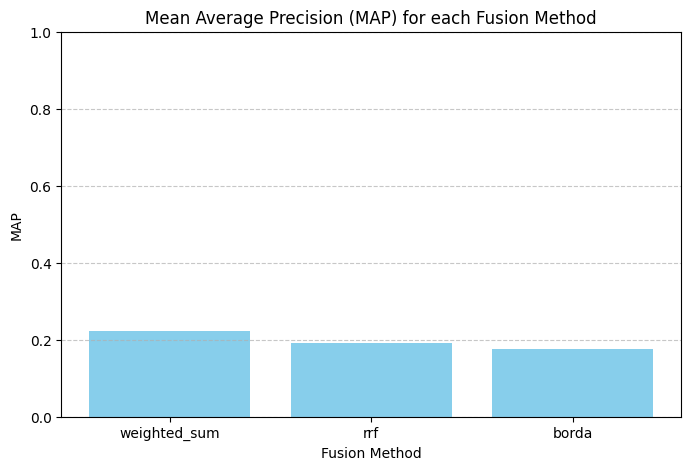

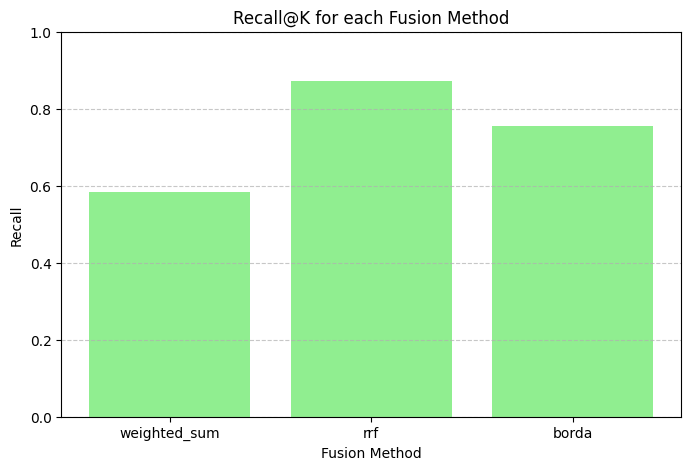

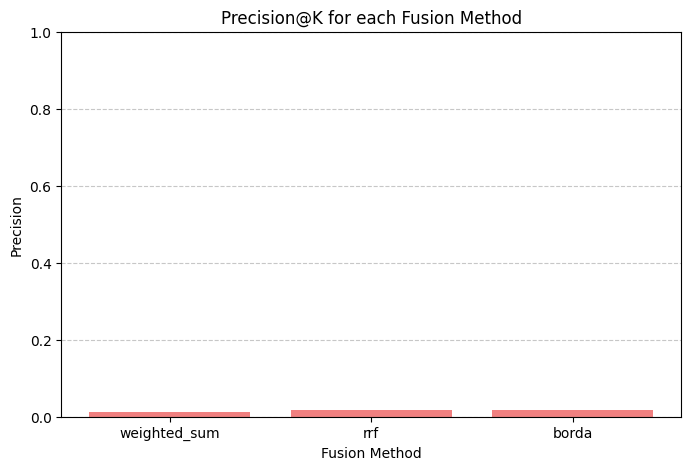

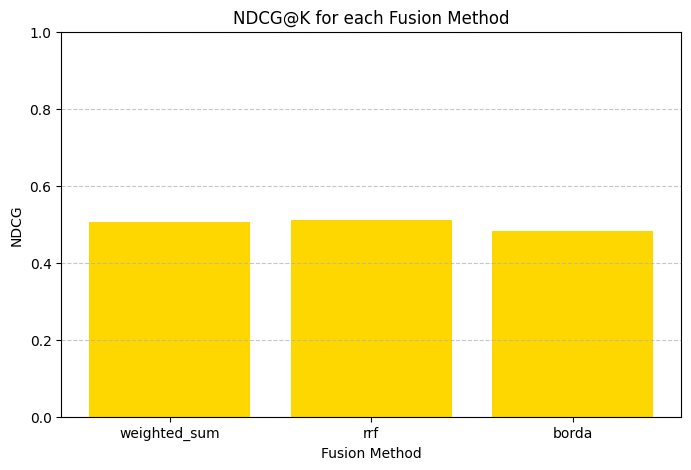

In [1]:
import requests
import csv
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score, ndcg_score
import numpy as np
import matplotlib.pyplot as plt

HYBRID_URL = "http://localhost:8005/search"
DATASET = "wikir"
FUSION_METHODS = ["weighted_sum", "rrf", "borda"]
TOP_K = 1000
DEBUG = True  # To print details for each query

# ----------------------------
# Load queries
# ----------------------------
def load_queries(path, num_queries=None):
    queries = []
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            queries.append({"query_id": row["query_id"], "query": row["text"]})
            if num_queries and len(queries) >= num_queries:
                break
    return queries

# Load qrels
def load_qrels(path):
    qrels = defaultdict(dict)
    with open(path, encoding="utf-8") as f:
        next(f)
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) < 3:
                continue
            qid, docid, rel = parts[:3]
            qrels[qid][docid] = int(rel)
    return qrels

# ----------------------------
# Send query to hybrid service
# ----------------------------
def search_fusion(query, method, dataset=DATASET, top_k=TOP_K):
    payload = {
        "dataset": dataset,
        "query": query,
        "top_k": top_k,
        "method": "fusion",
        "tfidf_weight": 0.4,
        "embedding_weight": 0.6,
    }
    response = requests.post(HYBRID_URL, json=payload)
    response.raise_for_status()
    results = response.json()["results"]
    filtered_results = [r for r in results if r.get("fusion_method") == method]
    return filtered_results

# ----------------------------
# Compute metrics
# ----------------------------
def compute_metrics(gt, pred_docs, pred_scores, top_k):
    hits = np.array([1 if doc in gt else 0 for doc in pred_docs])
    true_rels = np.array([gt.get(doc, 0) for doc in pred_docs])
    ap = average_precision_score(hits, pred_scores) if hits.sum() > 0 else 0.0
    precision = hits.sum() / top_k
    recall = hits.sum() / len(gt) if len(gt) > 0 else 0.0
    ndcg = ndcg_score([true_rels], [pred_scores]) if true_rels.sum() > 0 else 0.0
    return ap, precision, recall, ndcg

# ----------------------------
# Start evaluation
# ----------------------------
queries_path = r"D:\5th year\IR\Final_project_IR\data\vectors\wikir\processed\queries_cleaned.tsv"
qrels_path = r"D:\5th year\IR\Final_project_IR\data\vectors\wikir\qrels.tsv"

queries = load_queries(queries_path)  # Load all queries
qrels = load_qrels(qrels_path)

metrics = {m: {"AP": [], "Recall": [], "Precision": [], "NDCG": []} for m in FUSION_METHODS}
failed_queries = []

for q in tqdm(queries, desc=" Evaluating all queries"):
    qid = q["query_id"]
    query_text = q["query"]
    gt = qrels.get(qid, {})

    print(f"\n Query ID: {qid}")
    print(f" Query: {query_text}")
    print(f" Relevant docs: {len(gt)}")

    for method in FUSION_METHODS:
        try:
            results = search_fusion(query_text, method)
            pred_docs = [str(r["doc_id"]) for r in results[:TOP_K]]
            pred_scores = [r["score"] for r in results[:TOP_K]]
            ap, precision, recall, ndcg = compute_metrics(gt, pred_docs, pred_scores, TOP_K)

            metrics[method]["AP"].append(ap)
            metrics[method]["Recall"].append(recall)
            metrics[method]["Precision"].append(precision)
            metrics[method]["NDCG"].append(ndcg)

            print(f"   [Method: {method}]")
            print(f"    Precision@{TOP_K}: {precision:.4f}")
            print(f"    Recall@{TOP_K}: {recall:.4f}")
            print(f"    AP: {ap:.4f}")
            print(f"    NDCG@{TOP_K}: {ndcg:.4f}")
            print(f"     Top 5 Retrieved: {pred_docs[:5]}")
            print(f"     Relevant Retrieved: {[doc for doc in pred_docs[:5] if doc in gt]}")
        except Exception as e:
            print(f" Error in query_id={qid} with method {method}: {e}")
            metrics[method]["AP"].append(0)
            metrics[method]["Recall"].append(0)
            metrics[method]["Precision"].append(0)
            metrics[method]["NDCG"].append(0)
            failed_queries.append((qid, method))

# ----------------------------
# Final average results
# ----------------------------
print("\n === FINAL AVERAGE RESULTS ===")
for method in FUSION_METHODS:
    print(f"Fusion method: {method}")
    print(f"  MAP: {np.mean(metrics[method]['AP']):.4f}")
    print(f"  Recall@k: {np.mean(metrics[method]['Recall']):.4f}")
    print(f"  Precision@k: {np.mean(metrics[method]['Precision']):.4f}")
    print(f"  NDCG@k: {np.mean(metrics[method]['NDCG']):.4f}")

if failed_queries:
    print(f"\n Failed queries/methods: {failed_queries}")
else:
    print("\n All queries evaluated successfully!")

# ----------------------------
# Plotting charts
# ----------------------------
methods = FUSION_METHODS
map_scores = [np.mean(metrics[m]["AP"]) for m in methods]
recall_scores = [np.mean(metrics[m]["Recall"]) for m in methods]
precision_scores = [np.mean(metrics[m]["Precision"]) for m in methods]
ndcg_scores = [np.mean(metrics[m]["NDCG"]) for m in methods]

def plot_metric(metric_values, metric_name, ylabel, color):
    plt.figure(figsize=(8, 5))
    plt.bar(methods, metric_values, color=color)
    plt.title(f"{metric_name} for each Fusion Method")
    plt.xlabel("Fusion Method")
    plt.ylabel(ylabel)
    plt.ylim(0, 1)  # Metrics are between 0 and 1
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Plot each metric
plot_metric(map_scores, "Mean Average Precision (MAP)", "MAP", "skyblue")
plot_metric(recall_scores, "Recall@K", "Recall", "lightgreen")
plot_metric(precision_scores, "Precision@K", "Precision", "lightcoral")
plot_metric(ndcg_scores, "NDCG@K", "NDCG", "gold")
